In [1]:
%matplotlib inline

# Imports

In [2]:
import subprocess
from matplotlib import pyplot as plt

import json

from scipy import stats

# Custom function definitions

The important thing here is that you can type "RNAcofold" on the commmand line and not have errors. Ideally, the RNA library would be properly installed with the software so that you don't need some of this code below, but I've found that managing different versions of python (which you should be doing) can also make RNAlib installation difficult. But since my command line install of ViennaRNA worked, this code just calls that using the subprocess module and manually parsing the easy output to extract the pieces of information that I want

In [3]:
def get_energy_RNAcofold(stdout_string):
    """
    This function just processes the stdout data from RNAcofold and from it I extract
    the two different relevant energies.
    
    Inputs:
    
        stdout_string - bit string output from the "call_RNAcofold" fxn
        
    Outputs:
        
        ensemble_val - ensemble free energy extracted and processed as a float
        mfe_val - same as above, :s/ensemble/minimum
    
    """
    #Subprocess output is a bit string that needs to be decoded
    temp = stdout_string.decode("utf-8") 
        
    #Split the output into separate lines and some guess/check showed me which lines are which
    #First process the mfe line to get the associated value in parentheses
    mfe_line = temp.split('\n')[-4]
    mfe_val = mfe_line[mfe_line.index(' '):]
    mfe_val = mfe_val.strip().strip('()').strip()
    
    #Next process the ensemble energy line to get the associated value in brackets
    ensemble_line = temp.split('\n')[-3]
    ensemble_val = ensemble_line[ensemble_line.index(' '):]
    ensemble_val = ensemble_val.strip().strip('[]').strip()
    return float(ensemble_val), float(mfe_val)

def call_RNAcofold(sequence):
    """
    I don't know whether it makes sense to include dangling end energies or not but I suspect that
    the correct answer is "yes". Thus, use the "-d0" flag when calling RNAcofold
    
    Inputs:
    
        sequence - should be a string of RNA, can be in a fasta like format and should include
                    a constraint line
                    
    Outputs:
    
        stdout - a bit string encoding of the stdout from the bash call
    """
    ###Yes dangling end energies
    MyOut = subprocess.Popen(['RNAcofold', '-p', '--noPS', '--constraint'], 
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT)
    
    ###No dangling end energies
#     MyOut = subprocess.Popen(['RNAcofold', '-p', '-d0', '--noPS', '--constraint'], 
#             stdin=subprocess.PIPE,
#             stdout=subprocess.PIPE, 
#             stderr=subprocess.STDOUT)
    stdout, stderr = MyOut.communicate(input=str.encode(sequence))
    return stdout

# Creating all possible x-mers

In [4]:
# import string
import itertools


def generate_strings(chars, length=6):
    """
    Pretty straightforward implementation of the permutations
    
    Inputs:
        chars - a list of all possible characters as strings
        length - what length x-mers to construct
    
    Outputs:
        generator object of the x-mers joined as strings
    """
    for item in itertools.product(chars, repeat=length):
        yield ''.join(item)
        
fragments = list(generate_strings(['A','U','G','C'], length=6))
print(len(fragments), len(list(set(fragments))))

4096 4096


# Creating the dimer dictionary

For x-mers of length 6 this code takes ~a minute to run all 4,096. Longer x-mers will of course take proportionally more time (~linear with the length of fragments since calling `RNAcofold` really is almost instantaneous and the burden is in the iteration step).

The `constraint_pattern` variable below is REALLY important and prevents the dimers from hybridizing with any offset. This fact was previously ignored in past dictionaries that I have personally constructed, making them entirely wrong. However, I annoyingly found that the *actual* energy values that ViennaRNA returns depend weirdly on how many bases you "force" to hybridize. What I'd really like is to not force ANY base to hybridize but say that *if they do hybridize* then it has to be without any offset. This doesn't seem to be possible so I kind of think that the weakest constraints here might be the "best"?

An alternative might be to try several constraint patterns consisting only of two "((" for a particular fragment and select the strongest output?

In [26]:
asd_seq = 'CCUCCU' ###Can change, of course but his is the standard 6-mer aSD sequence

###Deciding which constraint pattern to enforce! Important!

# constraint_pattern = '((((((&))))))' ###Strongest constraint
# constraint_type = 'strongest'

# constraint_pattern = '.((((.&.)))).' ###Weaker constraint
# constraint_type = 'weak'

constraint_pattern = '..((..&..))..' ###Weakest constraint
constraint_type = 'weakest'

# constraint_pattern = '......&......' ###No constraint
# constraint_type = 'none'

#Starting with empty dictionaries
ensemble_energy_dicty = {}
mfe_energy_dicty = {}
#Iterating through the fragments and adding them
for fragment in fragments[:]:
    tempy = call_RNAcofold('>1\n{}&{}\n{}'.format(fragment,asd_seq,constraint_pattern))
    ensemble_energy, mfe_energy = get_energy_RNAcofold(tempy)
    ensemble_energy_dicty[fragment] = ensemble_energy
    mfe_energy_dicty[fragment] = mfe_energy

**Inspect these dictionaries**

In [27]:
items = list(mfe_energy_dicty.items())
sorted(items, key=lambda x: x[1])

[('AGGAGG', -8.6),
 ('GGGAGG', -8.6),
 ('CGGAGG', -8.4),
 ('UGGAGG', -8.2),
 ('AGGGGG', -7.7),
 ('GGGGGG', -7.7),
 ('CGGGGG', -7.5),
 ('UGGGGG', -7.3),
 ('AGGUGG', -7.0),
 ('AGGCGG', -7.0),
 ('GGGUGG', -7.0),
 ('GGGCGG', -7.0),
 ('AGGAGA', -6.8),
 ('GGGAGA', -6.8),
 ('CGGUGG', -6.8),
 ('CGGCGG', -6.8),
 ('UGGUGG', -6.6),
 ('UGGCGG', -6.6),
 ('CGGAGA', -6.6),
 ('UGGAGA', -6.4),
 ('AGGAGU', -6.3),
 ('GGGAGU', -6.3),
 ('CGGAGU', -6.1),
 ('AGGAGC', -6.0),
 ('GGGAGC', -6.0),
 ('AGGGGA', -5.9),
 ('UGGAGU', -5.9),
 ('GGGGGA', -5.9),
 ('CGGAGC', -5.8),
 ('CGGGGA', -5.7),
 ('UGGAGC', -5.6),
 ('UGGGGA', -5.5),
 ('AGGGGU', -5.4),
 ('GGGGGU', -5.4),
 ('AGAAGG', -5.3),
 ('AGUAGG', -5.3),
 ('AGCAGG', -5.3),
 ('GGAAGG', -5.3),
 ('GGUAGG', -5.3),
 ('GGCAGG', -5.3),
 ('AGGUGA', -5.2),
 ('AGGCGA', -5.2),
 ('GGGUGA', -5.2),
 ('GGGCGA', -5.2),
 ('CGGGGU', -5.2),
 ('AGGGGC', -5.1),
 ('GGGGGC', -5.1),
 ('CGAAGG', -5.1),
 ('CGUAGG', -5.1),
 ('CGCAGG', -5.1),
 ('UGGGGU', -5.0),
 ('CGGUGA', -5.0),
 ('CGGCGA', 

In [28]:
items = list(ensemble_energy_dicty.items())
sorted(items, key=lambda x: x[1])

[('AGGAGG', -8.83),
 ('GGGAGG', -8.83),
 ('CGGAGG', -8.43),
 ('UGGAGG', -8.23),
 ('AGGGGG', -7.93),
 ('GGGGGG', -7.93),
 ('CGGGGG', -7.54),
 ('UGGGGG', -7.34),
 ('AGGUGG', -7.24),
 ('AGGCGG', -7.24),
 ('GGGUGG', -7.24),
 ('GGGCGG', -7.24),
 ('AGGAGA', -7.0),
 ('GGGAGA', -7.0),
 ('CGGUGG', -6.84),
 ('CGGCGG', -6.84),
 ('UGGUGG', -6.64),
 ('UGGCGG', -6.64),
 ('CGGAGA', -6.61),
 ('AGGAGU', -6.51),
 ('GGGAGU', -6.51),
 ('UGGAGA', -6.41),
 ('AGGAGC', -6.22),
 ('GGGAGC', -6.22),
 ('AGGGGA', -6.11),
 ('GGGGGA', -6.11),
 ('CGGAGU', -6.11),
 ('UGGAGU', -5.91),
 ('CGGAGC', -5.82),
 ('CGGGGA', -5.71),
 ('UGGAGC', -5.62),
 ('AGGGGU', -5.61),
 ('GGGGGU', -5.61),
 ('AGAAGG', -5.54),
 ('AGUAGG', -5.54),
 ('AGCAGG', -5.54),
 ('GGAAGG', -5.54),
 ('GGUAGG', -5.54),
 ('GGCAGG', -5.54),
 ('UGGGGA', -5.51),
 ('AGGUGA', -5.42),
 ('GGGUGA', -5.42),
 ('GGGCGA', -5.42),
 ('AGGCGA', -5.41),
 ('AGGGGC', -5.32),
 ('GGGGGC', -5.32),
 ('CGGGGU', -5.22),
 ('CGAAGG', -5.14),
 ('CGUAGG', -5.14),
 ('CGCAGG', -5.14),
 (

In [29]:
print(ensemble_energy_dicty['AGGAGG'], mfe_energy_dicty['AGGAGG'])
print(ensemble_energy_dicty['GGAGGA'], mfe_energy_dicty['GGAGGA'])

-8.83 -8.6
-2.55 -2.3


**Write the dictionaries**

In [30]:
with open('../Data/energyRef_CCUCCU_ensemble_{}Constraint.json'.format(constraint_type), 'w') as outfile:
    json.dump(ensemble_energy_dicty, outfile)
with open('../Data/energyRef_CCUCCU_mfe_{}Constraint.json'.format(constraint_type), 'w') as outfile:
    json.dump(mfe_energy_dicty, outfile)

# Comparing outputs

**Just playing around to look at how correlated different dictionaries are with one another**

In [5]:
# with open('/Users/adamhockenberry/Downloads/json-energyRef-CCUCCU.txt', 'r') as infile:
#     dict_a = json.load(infile)
with open('../Data/energyRef_CCUCCU_ensemble_noneConstraint.json', 'r') as infile:
    dict_a = json.load(infile)
# with open('../Data/energyRef_CCUCCU_ensemble_weakestConstraint.json', 'r') as infile:
#     dict_a = json.load(infile)

In [11]:
with open('../Data/energyRef_CCUCCU_ensemble_maxConstraint.json', 'r') as infile:
    dict_b = json.load(infile)

In [12]:
listy_a = []
listy_b = []
for key in dict_a.keys():
    listy_a.append(dict_a[key])
    listy_b.append(dict_b[key])

SpearmanrResult(correlation=0.8607417651848811, pvalue=0.0)


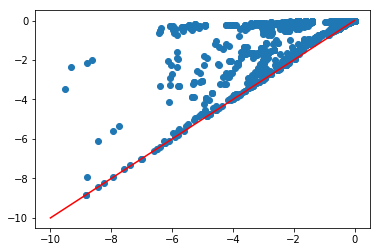

In [13]:
fig, ax = plt.subplots()
ax.scatter(listy_a, listy_b)
ax.plot([0, -10], [0, -10], 'r')
print(stats.spearmanr(listy_a, listy_b))

SpearmanrResult(correlation=0.533421795163928, pvalue=5.0840242656708474e-300)

# Scratch

Ignore below, for now

In [31]:
asd_seq = 'CCUCCU' ###Can change, of course but his is the standard 6-mer aSD sequence

###Deciding which constraint pattern to enforce! Important!
constraint_patterns = ['..((..&..))..', '.((...&...)).', '...((.&.))...'] 

#Starting with empty dictionaries
ensemble_energy_dicty = {}
mfe_energy_dicty = {}
#Iterating through the fragments and adding them
for fragment in fragments[:]:
    temp_ensemble = []
    temp_mfe = []
    for constraint_pattern in constraint_patterns:
        tempy = call_RNAcofold('>1\n{}&{}\n{}'.format(fragment,asd_seq,constraint_pattern))
        ensemble_energy, mfe_energy = get_energy_RNAcofold(tempy)
        temp_ensemble.append(ensemble_energy)
        temp_mfe.append(mfe_energy)
    ensemble_energy_dicty[fragment] = max(temp_ensemble)
    mfe_energy_dicty[fragment] = max(temp_mfe)

In [32]:
with open('../Data/energyRef_CCUCCU_ensemble_maxConstraint.json', 'w') as outfile:
    json.dump(ensemble_energy_dicty, outfile)
with open('../Data/energyRef_CCUCCU_mfe_maxConstraint.json', 'w') as outfile:
    json.dump(mfe_energy_dicty, outfile)

In [9]:
asd_seq = 'CCUCCU' ###Can change, of course but his is the standard 6-mer aSD sequence

###Deciding which constraint pattern to enforce! Important!
constraint_patterns = ['(.....&.....)', '.(....&....).',\
                       '..(...&...)..', '...(..&..)...', '....(.&.)....', '.....(&).....']
#Starting with empty dictionaries
ensemble_energy_dicty = {}
mfe_energy_dicty = {}
#Iterating through the fragments and adding them
for fragment in fragments[:]:
    temp_ensemble = []
    temp_mfe = []
    for constraint_pattern in constraint_patterns:
        tempy = call_RNAcofold('>1\n{}&{}\n{}'.format(fragment,asd_seq,constraint_pattern))
        ensemble_energy, mfe_energy = get_energy_RNAcofold(tempy)
        temp_ensemble.append(ensemble_energy)
        temp_mfe.append(mfe_energy)
    ensemble_energy_dicty[fragment] = max(temp_ensemble)
    mfe_energy_dicty[fragment] = max(temp_mfe)

In [10]:
with open('../Data/energyRef_CCUCCU_ensemble_maxConstraint.json', 'w') as outfile:
    json.dump(ensemble_energy_dicty, outfile)
with open('../Data/energyRef_CCUCCU_mfe_maxConstraint.json', 'w') as outfile:
    json.dump(mfe_energy_dicty, outfile)